# Product KPIs
### Get the data set, clean it up and extract the information needed (min, mean, max per day, var)

In [1]:
import numpy as np
import pandas as pd

#for creating charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for data processing 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
from scipy.optimize import curve_fit

import os

def get_ut(year, month, day):
    return calendar.timegm(datetime(int(year), int(month), int(day)).utctimetuple())

#template for rendering plots
class ShowContext():
    def __init__(self, xlabel='', ylabel='', title='', figsize=(9,7), show_legend=True):
        self._xlabel = xlabel
        self._ylabel = ylabel
        self._title = title
        self._figsize = figsize
        self._show_legend = show_legend
  
    def __enter__(self):
        self._figure = plt.figure(figsize=self._figsize)
    
    def __exit__(self, *args):
        plt.xlabel(self._xlabel)
        plt.ylabel(self._ylabel)
        plt.title(self._title)

        plt.grid(b=True, which='major', color='0.97', linestyle='-')
        plt.grid(b=True, which='minor', color='0.99', linestyle=':')
        plt.minorticks_on()
     
        if self._show_legend:
            plt.legend()


### Get data

In [6]:
data = pd.read_csv('Top7-2years.csv', na_values=['NA'])#read csv and mark all the missing values
data.head(10) #to see first 10 rows

,Date,Title,Dev Gross,Paying share,ARPPU,New paying users,Paying users,DAU
0,Total:,NaN,132025620.0,2.182,50,2570765.0,2526957.0,1198996.53
1,01.01.2017,NaN,125548.0,1.290,17,1176.0,6596.0,511450.00
2,NaN,Guns of Boom,270.0,0.041,11,15.0,24.0,58435.00
3,NaN,Airport City,21253.0,1.013,21,377.0,959.0,94651.00
4,NaN,Mirrors of Albion,25415.0,2.053,17,205.0,1498.0,72980.00
5,NaN,The Tribez,62807.0,1.305,18,470.0,3225.0,247182.00
6,NaN,Paradise Island 2,15646.0,2.378,13,106.0,878.0,36926.00
7,NaN,Mystery Manor,157.0,0.940,15,3.0,12.0,1276.00
8,02.01.2017,NaN,93219.0,1.111,14,1294.0,5847.0,526139.00
9,NaN,Guns of Boom,324.0,0.051,14,14.0,24.0,46723.00


In [9]:
data = data.loc[data['Date']!='Total:'] # delete "Total" row (the first one after the title)
data.head(10)

,Date,Title,Dev Gross,Paying share,ARPPU,New paying users,Paying users,DAU
1,01.01.2017,NaN,125548.0,1.290,17,1176.0,6596.0,511450.0
2,NaN,Guns of Boom,270.0,0.041,11,15.0,24.0,58435.0
3,NaN,Airport City,21253.0,1.013,21,377.0,959.0,94651.0
4,NaN,Mirrors of Albion,25415.0,2.053,17,205.0,1498.0,72980.0
5,NaN,The Tribez,62807.0,1.305,18,470.0,3225.0,247182.0
6,NaN,Paradise Island 2,15646.0,2.378,13,106.0,878.0,36926.0
7,NaN,Mystery Manor,157.0,0.940,15,3.0,12.0,1276.0
8,02.01.2017,NaN,93219.0,1.111,14,1294.0,5847.0,526139.0
9,NaN,Guns of Boom,324.0,0.051,14,14.0,24.0,46723.0
10,NaN,Airport City,19601.0,0.999,17,451.0,981.0,98234.0


In [12]:
data['Date'] = data['Date'].fillna(method='ffill') #to fill the missing cells in "Date" column
data.head(10)

,Date,Title,Dev Gross,Paying share,ARPPU,New paying users,Paying users,DAU,day,month
2,01.01.2017,Guns of Boom,270.0,0.041,11,15.0,24.0,58435.0,2017-01-01,2017-01-01
3,01.01.2017,Airport City,21253.0,1.013,21,377.0,959.0,94651.0,2017-01-01,2017-01-01
4,01.01.2017,Mirrors of Albion,25415.0,2.053,17,205.0,1498.0,72980.0,2017-01-01,2017-01-01
5,01.01.2017,The Tribez,62807.0,1.305,18,470.0,3225.0,247182.0,2017-01-01,2017-01-01
6,01.01.2017,Paradise Island 2,15646.0,2.378,13,106.0,878.0,36926.0,2017-01-01,2017-01-01
7,01.01.2017,Mystery Manor,157.0,0.940,15,3.0,12.0,1276.0,2017-01-01,2017-01-01
9,02.01.2017,Guns of Boom,324.0,0.051,14,14.0,24.0,46723.0,2017-01-02,2017-01-01
10,02.01.2017,Airport City,19601.0,0.999,17,451.0,981.0,98234.0,2017-01-02,2017-01-01
11,02.01.2017,Mirrors of Albion,14677.0,1.756,10,267.0,1397.0,79566.0,2017-01-02,2017-01-01
12,02.01.2017,The Tribez,41422.0,0.975,14,440.0,2545.0,260988.0,2017-01-02,2017-01-01


In [13]:
data = data.loc[~data['Title'].isnull()] # delete row with total numbers for month
data.head(10)

,Date,Title,Dev Gross,Paying share,ARPPU,New paying users,Paying users,DAU,day,month
2,01.01.2017,Guns of Boom,270.0,0.041,11,15.0,24.0,58435.0,2017-01-01,2017-01-01
3,01.01.2017,Airport City,21253.0,1.013,21,377.0,959.0,94651.0,2017-01-01,2017-01-01
4,01.01.2017,Mirrors of Albion,25415.0,2.053,17,205.0,1498.0,72980.0,2017-01-01,2017-01-01
5,01.01.2017,The Tribez,62807.0,1.305,18,470.0,3225.0,247182.0,2017-01-01,2017-01-01
6,01.01.2017,Paradise Island 2,15646.0,2.378,13,106.0,878.0,36926.0,2017-01-01,2017-01-01
7,01.01.2017,Mystery Manor,157.0,0.940,15,3.0,12.0,1276.0,2017-01-01,2017-01-01
9,02.01.2017,Guns of Boom,324.0,0.051,14,14.0,24.0,46723.0,2017-01-02,2017-01-01
10,02.01.2017,Airport City,19601.0,0.999,17,451.0,981.0,98234.0,2017-01-02,2017-01-01
11,02.01.2017,Mirrors of Albion,14677.0,1.756,10,267.0,1397.0,79566.0,2017-01-02,2017-01-01
12,02.01.2017,The Tribez,41422.0,0.975,14,440.0,2545.0,260988.0,2017-01-02,2017-01-01


In [14]:
data['day'] = data['Date'].apply(lambda s: datetime.strptime(s, '%d.%m.%Y')) #normalizing time
data['month'] = data['Date'].apply(lambda s: datetime.strptime(s, '%d.%m.%Y').replace(day=1))

data.head(n=13)

,Date,Title,Dev Gross,Paying share,ARPPU,New paying users,Paying users,DAU,day,month
2,01.01.2017,Guns of Boom,270.0,0.041,11,15.0,24.0,58435.0,2017-01-01,2017-01-01
3,01.01.2017,Airport City,21253.0,1.013,21,377.0,959.0,94651.0,2017-01-01,2017-01-01
4,01.01.2017,Mirrors of Albion,25415.0,2.053,17,205.0,1498.0,72980.0,2017-01-01,2017-01-01
5,01.01.2017,The Tribez,62807.0,1.305,18,470.0,3225.0,247182.0,2017-01-01,2017-01-01
6,01.01.2017,Paradise Island 2,15646.0,2.378,13,106.0,878.0,36926.0,2017-01-01,2017-01-01
7,01.01.2017,Mystery Manor,157.0,0.940,15,3.0,12.0,1276.0,2017-01-01,2017-01-01
9,02.01.2017,Guns of Boom,324.0,0.051,14,14.0,24.0,46723.0,2017-01-02,2017-01-01
10,02.01.2017,Airport City,19601.0,0.999,17,451.0,981.0,98234.0,2017-01-02,2017-01-01
11,02.01.2017,Mirrors of Albion,14677.0,1.756,10,267.0,1397.0,79566.0,2017-01-02,2017-01-01
12,02.01.2017,The Tribez,41422.0,0.975,14,440.0,2545.0,260988.0,2017-01-02,2017-01-01


In [16]:
d2 = data.groupby(['month', 'Title']).agg({'Dev Gross': ['min', 'mean', 'max']} #group by columns
                                         ).reset_index()
d2.columns = ['month', 'title', 'min_gross', 'mean_gross', 'max_gross'] #rename columns 

d2

,month,title,min_gross,mean_gross,max_gross
0,2017-01-01,Airport City,13589.0,28883.064516,84886.0
1,2017-01-01,Guns of Boom,77.0,380.225806,923.0
2,2017-01-01,Mirrors of Albion,11167.0,17725.774194,27676.0
3,2017-01-01,Mystery Manor,27.0,168.548387,1710.0
4,2017-01-01,Paradise Island 2,2540.0,14045.677419,44417.0
5,2017-01-01,The Tribez,20563.0,42395.129032,86083.0
6,2017-02-01,Airport City,20745.0,36725.250000,96320.0
7,2017-02-01,Guns of Boom,218.0,796.892857,1434.0
8,2017-02-01,Mirrors of Albion,12936.0,18577.321429,32274.0
9,2017-02-01,Mystery Manor,21.0,144.357143,321.0


## Creating charts HeartBeat (min, mean, max per day)

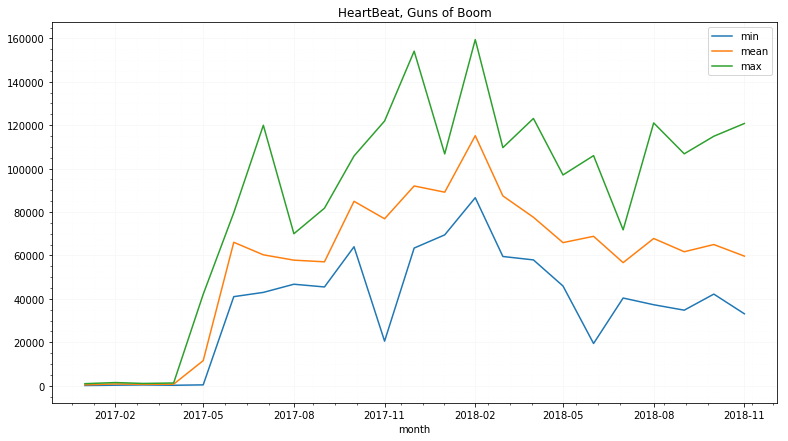

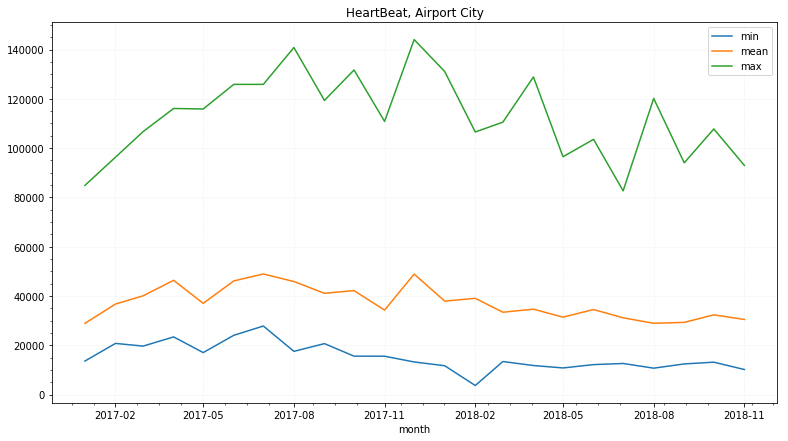

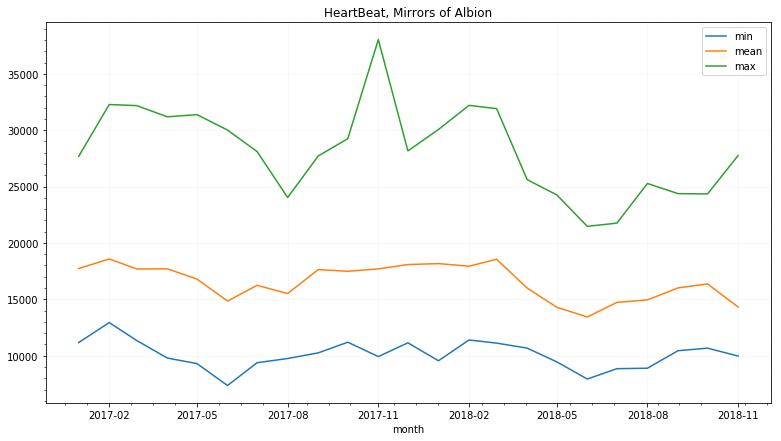

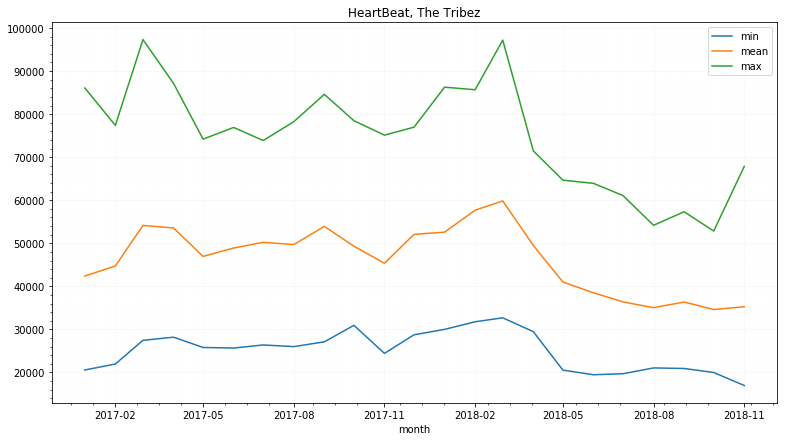

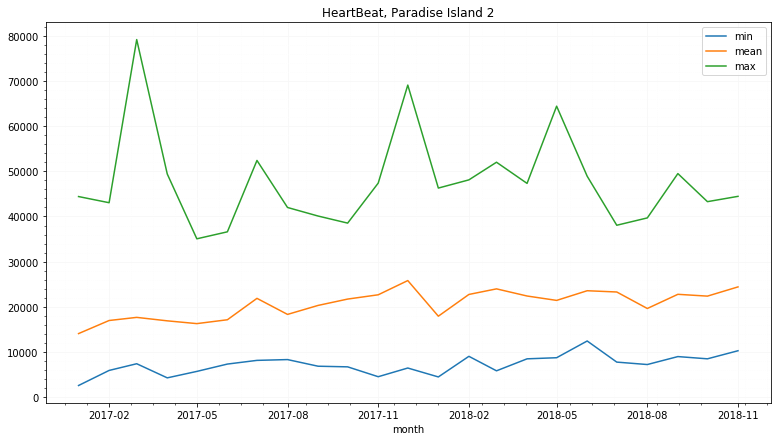

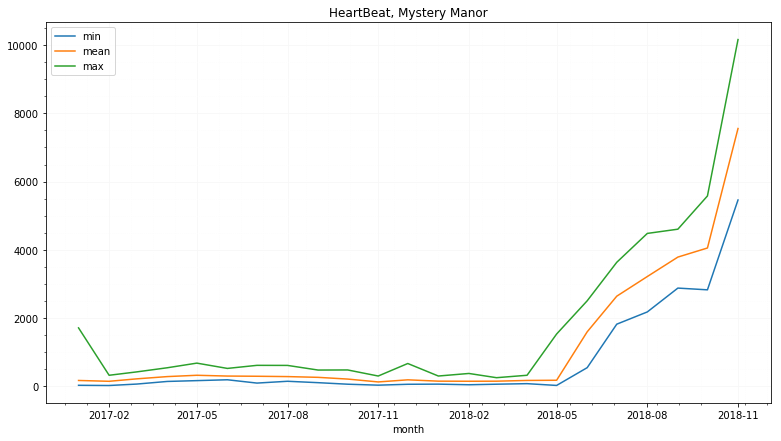

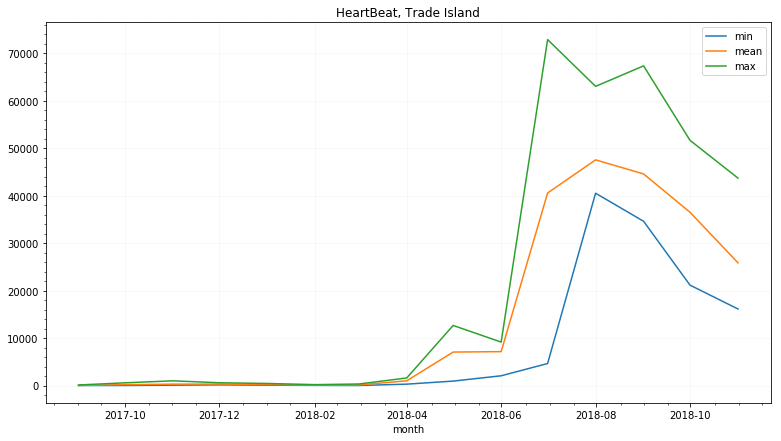

In [17]:
# All project titles
title = ['Guns of Boom', 'Airport City', 'Mirrors of Albion', 'The Tribez', 'Paradise Island 2', 'Mystery Manor', 'Trade Island']

for i in title:
    d3 = d2.loc[d2['title']== i]
    with ShowContext('month', '', 'HeartBeat, '+i, figsize=(13,7)) as sc:
        plt.plot(d3['month'], d3['min_gross'], label='min')
        plt.plot(d3['month'], d3['mean_gross'], label='mean')
        plt.plot(d3['month'], d3['max_gross'], label='max')


## var (std/mean)

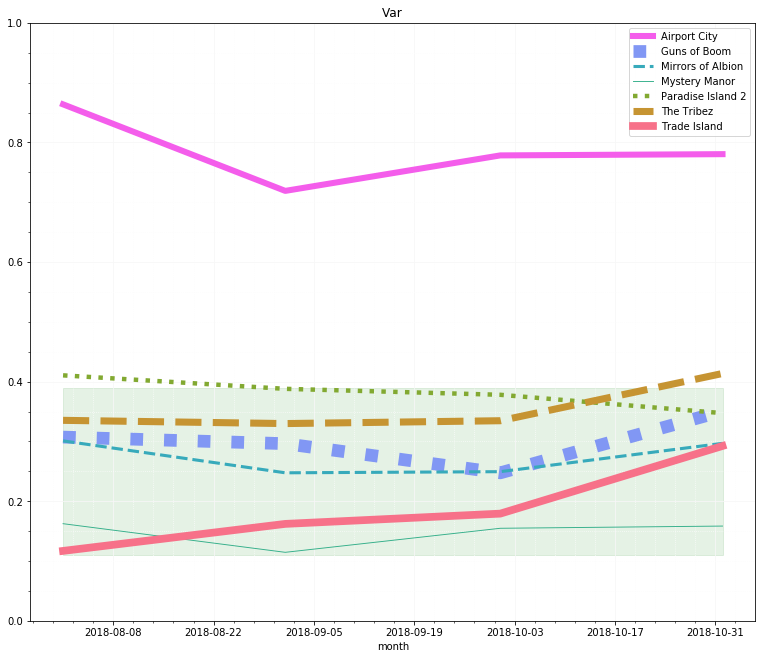

In [19]:
d4 = data.groupby(['month', 'Title']).agg({'Dev Gross': ['mean', 'std']}
                                          ).reset_index()
d4.columns = ['month', 'title', 'mean_gross', 'std_gross']
d4['var'] = d4['std_gross']/d4['mean_gross']
d4 = d4[d4["month"].isin(pd.date_range("2018-08-01", "2018-11-01"))] #for a certain period


style = {0: '-', 
         1:':', 
         2: '--'} #style of the lines

palette = sns.color_palette('husl', len(d4['title'].unique()))
i = 0
with ShowContext('month', '', 'Var', figsize=(13,11)) as sc:
    for title, group in d4.groupby('title'):
        color = palette.pop()
        plt.plot(group['month'], group['var'], label=title, color=color, 
                 linestyle=style[i%3], linewidth=group['mean_gross'].mean()/5000) #the thickness of the line will depend on this value for each project
        i += 1
        
    plt.fill_between(sorted(d4['month'].unique()), 0.11, 0.39, color='green', alpha=0.1)
    plt.ylim(0,1)
